In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from torchvision import transforms

EPOCH = 10
learningrate = 0.001
mnist_csvfile = "F:/Dataset/MNIST/mnist_train.csv"
mnist_rootdir = "F:/Dataset/MNIST/"

In [24]:
# 首先创建模型
class SSDA(nn.Module):
    def __init__(self):
        super(SSDA, self).__init__()
        self.fc1 = nn.Linear(28*28, 1000)
        self.fc2 = nn.Linear(1000, 28*28)
        
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

class ToTensor(object):
    def __call__(self, sample):
        img_label, img_data = sample['img_label'], sample['img_data']
        # 将np数组变成tensor
        img_data = torch.from_numpy(img_data.reshape(1, -1))
        return {'img_label':img_label, 'img_data':img_data}     

transCompose = transforms.Compose([ToTensor()])
    
class MNIST(Dataset):
    def __init__(self, csvfile, root_dir, transform=None):
        self.dataframe = pd.read_csv(csvfile)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_label = self.dataframe.iloc[idx, 0]
        img_label = str(img_label)
        img_data = self.dataframe.iloc[idx, 1:]
        img_data = np.array([img_data]).astype('float32').reshape(1, -1)
        sample = {'img_label':img_label, 'img_data':img_data}
        if self.transform:
            sample = self.transform(sample)
            
        return sample  

In [25]:
mnist_trainset = MNIST(mnist_csvfile, mnist_rootdir, transCompose)
mnist_dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=1, shuffle=True, num_workers=0)

net = SSDA()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
criterion = nn.MSELoss()
for epoch in range(EPOCH):
    running_loss = 0.0
    for i, data in enumerate(mnist_dataloader):
        label = data['img_label']
        img_data = data['img_data']/255
        noise = torch.from_numpy(np.random.normal(0, 50/(255*255), img_data.size()).astype('float32'))
        noise_data = img_data+noise
        noise_data.requires_grad = True
        optimizer.zero_grad()
        output = net(noise_data.squeeze())
        t = noise_data-output
        loss = torch.mean(t.pow(2))
        loss.backward()
        optimizer.step()
        running_loss +=loss.item()
        if i%1999 == 0:
            print('[%d, %5d] loss: %.3f'%(epoch+1, i+1, running_loss))
            running_loss = 0.0

[1,     1] loss: 0.234
[1,  2000] loss: 166.785
[1,  3999] loss: 137.583
[1,  5998] loss: 134.811
[1,  7997] loss: 134.337
[1,  9996] loss: 132.324
[1, 11995] loss: 132.744
[1, 13994] loss: 131.676
[1, 15993] loss: 131.060
[1, 17992] loss: 128.692
[1, 19991] loss: 128.322
[1, 21990] loss: 126.163
[1, 23989] loss: 126.194
[1, 25988] loss: 124.268
[1, 27987] loss: 123.579
[1, 29986] loss: 120.974
[1, 31985] loss: 116.969
[1, 33984] loss: 116.397
[1, 35983] loss: 114.356
[1, 37982] loss: 111.808
[1, 39981] loss: 110.243
[1, 41980] loss: 108.065
[1, 43979] loss: 106.411
[1, 45978] loss: 104.361
[1, 47977] loss: 102.633
[1, 49976] loss: 101.131
[1, 51975] loss: 99.154
[1, 53974] loss: 96.629
[1, 55973] loss: 96.252
[1, 57972] loss: 95.626
[1, 59971] loss: 93.149
[2,     1] loss: 0.085
[2,  2000] loss: 91.686
[2,  3999] loss: 91.541
[2,  5998] loss: 90.100
[2,  7997] loss: 89.238
[2,  9996] loss: 87.496
[2, 11995] loss: 87.922
[2, 13994] loss: 86.005
[2, 15993] loss: 84.983
[2, 17992] loss: 

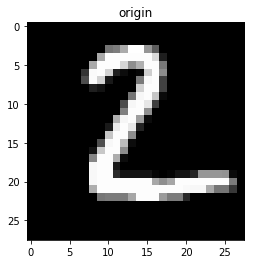

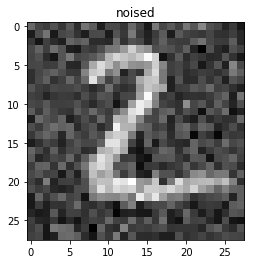

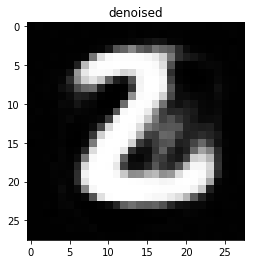

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
# 读取一张图片并可视化
samples = pd.read_csv(os.path.join(mnist_rootdir, 'mnist_test.csv'))
sample = samples.iloc[0, 1:]
img_data = torch.tensor(sample, dtype=torch.float)
plt.ion()
plt.figure(),plt.imshow(img_data.numpy().reshape((28, -1)), cmap='gray'),plt.title("origin")
noise = torch.from_numpy(np.random.normal(0, 50, img_data.size()).astype('float32'))
noise_data = img_data+noise
plt.figure(),plt.imshow(noise_data.numpy().reshape((28, -1)), cmap='gray'),plt.title("noised")
output = net(noise_data)
plt.figure(),plt.imshow(output.detach().numpy().reshape((28, -1)), cmap='gray'),plt.title("denoised")
plt.ioff()
plt.show()


In [30]:
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())
    
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])
    

fc1.weight 	 torch.Size([1000, 784])
fc1.bias 	 torch.Size([1000])
fc2.weight 	 torch.Size([784, 1000])
fc2.bias 	 torch.Size([784])
state 	 {2620545132440: {'momentum_buffer': tensor([[-6.8466e-08,  7.2386e-08, -7.0266e-09,  ...,  3.1605e-08,
          1.5192e-08,  3.9073e-10],
        [-1.7212e-08,  2.2939e-08,  1.3433e-08,  ..., -2.3311e-08,
         -1.8118e-08, -4.0475e-08],
        [-1.3214e-08,  3.6919e-08,  8.7342e-09,  ..., -9.2196e-09,
         -1.9011e-09, -3.5600e-08],
        ...,
        [ 4.2042e-08,  6.8676e-08,  6.3180e-08,  ...,  1.8739e-08,
         -5.3097e-08, -3.3966e-08],
        [ 3.3545e-08, -2.1209e-08, -2.4395e-08,  ..., -4.2062e-08,
         -2.5071e-08, -4.3298e-08],
        [ 6.6208e-09,  4.9775e-08,  4.4865e-08,  ..., -6.6145e-09,
         -1.8831e-08, -3.1534e-08]])}, 2620545132512: {'momentum_buffer': tensor([ 1.3494e-04, -1.7775e-07, -5.0674e-07,  9.1907e-05, -5.1625e-05,
        -2.3154e-05,  6.8795e-06,  3.9368e-05,  1.4278e-04, -2.9417e-06,
        

         3.1007e-07,  3.5761e-07,  3.2856e-07,  2.5971e-07])}}
param_groups 	 [{'lr': 0.01, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [2620545132440, 2620545132512, 2620545134528, 2620545134384]}]


In [33]:
torch.save(net.state_dict(), "./checkpoint/DA/mnist.pkl")
net.load_state_dict(torch.load("./checkpoint/DA/mnist.pkl"))